# Import

In [1]:
# imports
import json
import math
import bisect
import numpy as np
import pandas as pd
import mediapipe as mp
import ipywidgets as widgets
import tensorflow as tf
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from mediapipe.framework.formats import landmark_pb2
from fastai.vision.all import show_image
from ipywidgets import interact, interactive, fixed, interact_manual
from collections import Counter

# functions
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

# Data

In [2]:
# path to a single data file
file = '33432165'
path_dataset = '/Volumes/My Passport for Mac/asl-fingerspelling/supplemental_landmarks/' + file + '.parquet'
path_dataset_labels = '/Volumes/My Passport for Mac/asl-fingerspelling/supplemental_metadata.csv'
dataset = pd.read_parquet(path_dataset)
dataset_labels = pd.read_csv(path_dataset_labels)

## Video Selection

In [3]:
# Video ID
VideoID = dataset.index.unique() # 1000 total videos

# Select a video
s = 4
seq_id = VideoID[s]  

# Select video data
data = dataset.loc[ seq_id ]
data_labels = dataset_labels.loc[ dataset_labels['sequence_id'] == seq_id ]
phrase = data_labels.phrase.iloc[0]

# head
data_labels.head()

,path,file_id,sequence_id,participant_id,phrase
4,supplemental_landmarks/33432165.parquet,33432165,1535585216,254,knee bone is connected to the thigh bone


# Data Labels
### Functions

In [156]:
# List of characters present in the sentence
def character_list(sentence):
    ans = []
    words = sentence.split()
    for word in words:
        prev = ''
        for i in word:
            if i in prev or not prev: 
                prev += i
            else:
                ans += [prev]
                prev = i       
        ans += [ prev ]
    return ans

In [557]:
# Columns info
Signers = dataset_labels.participant_id.unique() # All signers
Sentences = dataset_labels.phrase.unique() # All sentences 

# Characters counts
Sentences_Characters = [character_list(i) for i in Sentences] # Convert each sentence into list of characters
Character_Counts = Counter( sum(Sentences_Characters, []) ) # Count characters across all sentences

# Convert to a sorted list
Characters = sorted(list(Character_Counts))

# Encoding and decoding characters as integers
Encode, Decode = {}, {}
for i,x in enumerate(Characters):
    Encode[x] = i
    Decode[i] = x

## Exploritory Data Analysis

In total, there are approximately 50,000 videos in the data set which are done by 72 distinct participants. For each video, the participant will spell out the letters of a sentence that is provided to them. The sentences are often reused, so there are multiple videos of different participant spelling out the same sentence. 

Here is a quick summary of the data:

* Total Videos: 52,958
* Total Participants: 72
* Total Distinct Sentences: 508
* Total Distinct Characters: 40

Below is a plot for number of videos each signer performed. 

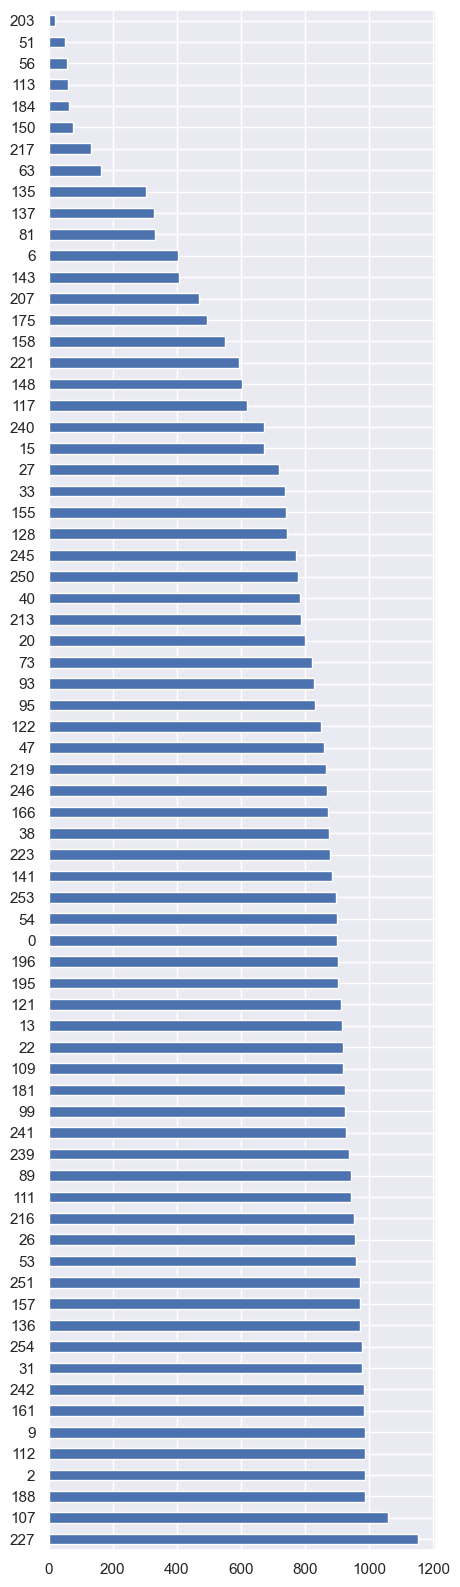

In [177]:
# Counts
signers_count = dataset_labels['participant_id'].value_counts() # Count of videos per signer
sentences_count = dataset_labels['phrase'].value_counts() # Count of videos per sentence

# plotting number of videos per signer
ax = signers_count.plot(kind='barh', figsize=(5,20))

### Character Plot

In [190]:
Characters

['a',
 'b',
 'c',
 'cc',
 'd',
 'dd',
 'e',
 'ee',
 'f',
 'ff',
 'g',
 'gg',
 'h',
 'i',
 'j',
 'k',
 'l',
 'll',
 'm',
 'mm',
 'n',
 'nn',
 'o',
 'oo',
 'p',
 'pp',
 'q',
 'r',
 'rr',
 's',
 'ss',
 't',
 'tt',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'zz']

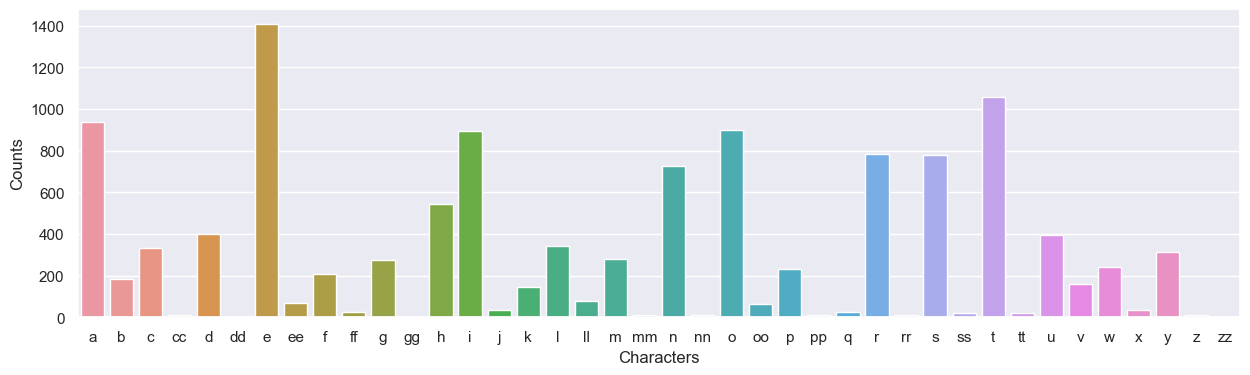

In [179]:
sns.set(rc={"figure.figsize":(15, 4)})
counts_df = pd.DataFrame(data = { 'Characters' : Characters, 'Counts' : [Character_Counts[i] for i in Characters] } )
ax = sns.barplot(x='Characters', y='Counts', data = counts_df)
# [ i for i in Sentences if "ff" in i] 

As is common with the english language, each characters appear with a different frequency. The characters with the highest frequency are:

In [113]:
counts_df.sort_values(by=['Counts'], ascending = False).head(8)

,Characters,Counts
6,e,1409
31,t,1057
0,a,937
22,o,899
13,i,897
27,r,785
29,s,780
20,n,726


The characters with the lowest frequency are divided into two categories: 

1. single letters (e.g. q) 
2. double letters (e.g. tt in the word "better")

In the latter case, the signer holds the sign for a given letter while doing "bobbing" or "sliding" motion with their hand to indicate multiple occurances of the letter. The specific letters that are doubled in the data are cc, dd, ee, ff, gg, ll, mm, nn, oo, pp, rr, ss, tt, and zz. 

The single characters with the lowest frequencies are listed below:

In [131]:
counts_df[ counts_df.Characters.str.len() == 1 ].sort_values(by=['Counts']).head(8)

,Characters,Counts
38,z,12
26,q,26
36,x,34
14,j,35
15,k,143
34,v,161
1,b,183
8,f,208


The double characters with the lowest frequencies are listed below:

In [130]:
counts_df[ counts_df.Characters.str.len() == 2 ].sort_values(by=['Counts'])

,Characters,Counts
39,zz,1
11,gg,2
5,dd,3
19,mm,9
25,pp,9
28,rr,10
3,cc,12
21,nn,13
30,ss,19
32,tt,21


## Data 
<p> Column Labels

In [89]:
# EDA - Exploratory data analysis
# data.shape # (n,k): n = number of frames in video, k = (k-1 pieces of landmark data) + (1 frame data)

# Landmark data
#### Divide columns into frame number, and landmarks for face, left_hand / right_hand, and pose. 
#    Each of the landmark columns are divided into three based on the x,y,z coordinates. We list
#    total number of xyz columns for landmarks and then the unique landmarks. Links:
#       - Pose:  https://developers.google.com/mediapipe/solutions/vision/pose_landmarker
#       - Hands: https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/index
################################################################################################
C = data.columns
frame = C[0] # 1 frame 
face = [ i for i in C if 'face' in i] # 1404 xyz columns / 468 landmarks
left_hand = [ i for i in C if 'left_hand' in i] # 63 xyz columns / 21 landmarks 
right_hand = [ i for i in C if 'right_hand' in i] # 63 xyz columns / 21 landmarks  
pose = [ i for i in C if 'pose' in i] # 99 xyz columns / 33 landmarks

# quick look
data.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1535585216,0,0.661311,0.639197,0.649397,0.627107,0.636819,0.637886,0.643963,0.543379,0.643512,...,-0.446071,-0.475024,-0.276392,-0.399065,-0.411691,-0.411123,-0.291026,-0.377121,-0.383896,-0.384064
1535585216,1,0.658771,0.638368,0.648412,0.627044,0.636141,0.637413,0.643941,0.544614,0.643753,...,-0.249128,-0.267379,-0.132248,-0.242402,-0.264498,-0.256052,-0.156172,-0.240920,-0.255348,-0.249507
1535585216,2,0.660224,0.637203,0.647146,0.626657,0.635131,0.636633,0.643726,0.546612,0.643891,...,-0.206395,-0.213511,-0.103286,-0.200041,-0.212501,-0.197073,-0.128849,-0.205215,-0.215801,-0.205451
1535585216,3,0.659946,0.638108,0.647697,0.627808,0.636125,0.637637,0.644620,0.548416,0.644791,...,-0.189114,-0.194932,-0.109138,-0.186973,-0.185710,-0.168197,-0.133141,-0.194085,-0.197469,-0.186459
1535585216,4,0.659748,0.639185,0.648541,0.628934,0.637253,0.638732,0.645578,0.550669,0.645741,...,-0.156095,-0.157589,-0.086654,-0.150850,-0.144399,-0.124004,-0.107844,-0.156168,-0.154891,-0.139937


# Landmarks
## Import functions 

In [269]:
# Number of landmarks per object
number_of_landmarks = { 'face' : 468, 'left_hand' : 21, 'right_hand' : 21, 'pose' : 33 }

# simple holder for our landmarks that will mimic the results that we get back from mediapipe but using our data
class Landmarks(object):
    pass

# Returns a "Landmark object" with a list of landmarks for the given object and frame   
def get_landmarks(name, data, frame):
    
    # assert that name is face, left_hand, right_hand, pose
    assert name in {'face', 'left_hand', 'right_hand', 'pose'}
    
    # number of landmarks per object
    n = number_of_landmarks[name]
    
    # loop
    obj = landmark_pb2.NormalizedLandmarkList()
    for i in range(n):
        
        # Column names in the data (dataframe) for the x,y,z coordinates of landmark i
        coordinates = {}
        for j in "xyz":
            column_name = j + '_' + name + '_' + str(i)
            coordinates[j] = data[ column_name ].loc[ data['frame'] == frame ]
        
        # coordinates
        xi,yi,zi = coordinates['x'], coordinates['y'], coordinates['z']
        
        # add to Landmark
        obj.landmark.add( x=xi, y=yi, z=zi )
    
    # return 
    return obj


# Creates all landmarks 
def get_landmarks_data(data, frame):  
    result = Landmarks()
    result.face_landmarks = get_landmarks('face', data, frame)
    result.pose_landmarks = get_landmarks('pose', data, frame)
    result.left_hand_landmarks = get_landmarks('left_hand', data, frame)
    result.right_hand_landmarks = get_landmarks('right_hand', data, frame)
    return result

## Operations

In [270]:
# Checks if a landmark is not defined
def Landmark_is_nan(X):
    for i in X.landmark:
        if math.isnan(i.x) or math.isnan(i.y) or math.isnan(i.z):
            return True
    return False

# returns <x,y,z> vector for landmark n
def Landmark_vector(X,i):
    return np.array([ X.landmark[i].x,  X.landmark[i].y,  X.landmark[i].z])
    
# Makes a blank landmark of length n
def Landmark_blank(n):
    obj = landmark_pb2.NormalizedLandmarkList()
    for i in range(n):
        obj.landmark.add( x=math.nan, y=math.nan, z=math.nan )
    return obj

# Creates a blank for all landmarks
def blank():  
    result = Landmarks()
    result.face_landmarks = Landmark_blank(468)
    result.pose_landmarks = Landmark_blank(33)
    result.left_hand_landmarks = Landmark_blank(21)
    result.right_hand_landmarks = Landmark_blank(21)
    return result
    
# Makes a landmark undefined
def Landmark_make_nan(X):
    obj = landmark_pb2.NormalizedLandmarkList()
    for i in X.landmark:
        obj.landmark.add( x=math.nan, y=math.nan, z=math.nan )
    return obj


# Shifts a landmark to be centered at the vector w
def shift(X,w):
    obj = landmark_pb2.LandmarkList()
    a = np.array([ X.landmark[0].x , X.landmark[0].y, X.landmark[0].z ]) 
    for i in X.landmark:
        # form vector
        v = np.array([i.x,i.y,i.z])
        # unshift affine shift
        v = v - a + w
        # set coordinates
        obj.landmark.add( x=v[0], y=v[1], z=v[2] )       
    return obj 


# reflects a landmark about the y-axis
def reflect(X):
    obj = landmark_pb2.LandmarkList()
    for i in X.landmark:
        obj.landmark.add( x=(.5-i.x), y=i.y, z=i.z )       
    return obj 

# records whether front or back of hand
def front(X):
    
    # points
    X0 = Landmark_vector(X,0) # base
    X5 = Landmark_vector(X,5) # left 
    X17 = Landmark_vector(X,17) # right
    
    # vectors 
    V1, V2 = X5 - X0, X17 - X0
    
    # set z to 0 
    V1[2], V2[2] = 0,0
    
    # take cross product
    n = np.cross(V1,V2)
    
    return True if n[2] < 0 else False  

## Centering

In [337]:
M = np.array([[ 0.06816408, -0.02943546, -0.0151578 ], [ 0.04396006, -0.13104451, -0.0048572 ], [-0.05505851, -0.10182643, -0.04996139]])
U, S, V = np.linalg.svd(M, full_matrices=True)
U.dot(V)

array([[ 0.78729251, -0.01747375, -0.61633203],
       [ 0.31131621, -0.85156091,  0.42181303],
       [-0.53221492, -0.52396439, -0.66498766]])

In [348]:
# Recenters a hand based on the outer landmarks 
def center(X, frame):
    
    # if not defined
    if Landmark_is_nan(X): return X

    # Centering
    X0 = Landmark_vector(X,0) # base
    X1 = Landmark_vector(X,1) # left 
    X5 = Landmark_vector(X,5) # center left 
    X9 = Landmark_vector(X,9) # center
    X13 = Landmark_vector(X,13) # center right
    X17 = Landmark_vector(X,17) # right
        
    # Basis 1
    V1, V5, V9, V13, V17, = X1-X0, X5-X0, X9-X0, X13-X0, X17-X0
    

    # Basis Matrices
    A, B = np.array([V1,V5,V17]),    np.array([[ 0.06816408, -0.02943546, -0.0151578 ], [ 0.04396006, -0.13104451, -0.0048572 ], [-0.05505851, -0.10182643, -0.04996139]])
    A1, B1 = np.array([V9,V5,V17]),  np.array([[ 0.12737696, -0.07470322, -0.08873697], [ 0.12005465, -0.11204314, -0.07280551], [ 0.13797943,  0.01287234, -0.11509396]])
    # A, B = np.array([V1,V2,V3]),  np.array([[ 0.04693469, -0.12667215, -0.0208972 ],[ 0.00329348, -0.12194675, -0.03340138],[-0.07567593, -0.0876869 , -0.06737784]])

    # Transformation
    C = (np.linalg.inv(A)).dot(B)
    if not front(X): C = (np.linalg.inv(A1)).dot(B1)
    
    # SVD
    U, S, V = np.linalg.svd(C, full_matrices=True)
    C = U.dot(V)
    
    # print( np.linalg.det(C), (np.linalg.norm(V5) / np.linalg.norm(V17) ), np.dot(V5,V17) / (np.linalg.norm(V5) * np.linalg.norm(V17))  )
    
    obj = landmark_pb2.LandmarkList()
    for i in X.landmark:
            
            # form vector
            v = np.array([i.x,i.y,i.z])
            
            # affine shift
            v = v - X0
            
            # linear transformation
            v = v.dot(C)
            
            # set coordinates
            obj.landmark.add( x=v[0], y=v[1], z=v[2] )
            
    return obj 

# Video class

In [182]:
# Video Class
class video:           
    def __init__(self,seq_id):
        self.id = seq_id 
        self.label = dataset_labels.loc[ dataset_labels['sequence_id'] == seq_id  ]
        self.phrase = self.label.phrase.iloc[0]
        self.participant = self.label.participant_id.iloc[0]
        self.data = dataset.loc[ seq_id ]
        self.frames = self.data.frame
        self.characters = character_list(self.phrase)
    
    def __repr__(self): 
            a = " Sequence: {0}\n Phrase: {1}\n Signer: {2}\n Frames: {3}\n Dominant Hand: {4}\n Percentage: {5}".format( self.id, 
                                                                                                                          self.phrase,
                                                                                                                          self.participant, 
                                                                                                                          len(self.frames), 
                                                                                                                          dominant_hand(self), 
                                                                                                                          percentage(self))

            return a 
#######################
### Video functions ###
#######################

def sequence(self):
    return self.id

def participant(self):
    return self.participant

def phrase(self):
    return self.phrase

def video_data(self):
    return self.data

def frames(self):
    return self.frames

def characters(self):
    return self.characters

def percentage(self):
    return round( 100 * len( hand_frames(self) ) / len( self.frames ), 2)
    

#######################
#### Dominant Hand ####
#######################

def dominant_hand(self):
    if hasattr(self, 'dominant_hand'):
        return self.dominant_hand
    
    # Select all frames from data
    data = self.data
    frames = data.frame.unique()
    
    # Left / right hand frames
    Lframes = [i for i in frames if not Landmark_is_nan(get_landmarks('left_hand',  data, i))]
    Rframes = [i for i in frames if not Landmark_is_nan(get_landmarks('right_hand', data, i))] 
    
    # Determine dominant hand 
    if len(Lframes) < len(Rframes):
        self.handframes = Rframes
        self.dominant_hand = 'right'
    else:
        self.handframes = Lframes
        self.dominant_hand = 'left'
    
    return self.dominant_hand

### Dominant hand frames
def hand_frames(self):
    dominant_hand(self) # this assigns handframes
    return self.handframes

#######################
### Normalized hand ###
#######################

def normal_hand_data(self):
    
    if hasattr(self, 'normal_hand_data'):
        return self.normal_hand_data, self.hand_position
    
    # hand frames 
    data = self.data
    Hframes = hand_frames(self)
    Dhand = dominant_hand(self)
    
    # loop 
    L, P = [], [] 
    for frame in Hframes:

        # Select landmarks for dominant hand
        X = get_landmarks_data(data, frame).right_hand_landmarks if Dhand == 'right' else get_landmarks_data(data, frame).left_hand_landmarks

        # First store position
        P.append( list(Landmark_vector(X,0)) )

        # center landmark
        X = center(X, frame)

        # List
        L.append( [ list(Landmark_vector(X,i)) for i in range(1,21) ] )

    # assign to video
    self.normal_hand_data, self.hand_position = L, P
    
    # return 
    return self.normal_hand_data, self.hand_position
          

In [435]:
V = video(seq_id)
D = video_data(V)

In [436]:
print(V)

 Sequence: 1535585216
 Phrase: knee bone is connected to the thigh bone
 Signer: 254
 Frames: 245
 Dominant Hand: right
 Percentage: 100.0


## Exploritory Data Analysis

We now do some basic exploritory data analysis on the 1000 sequences in the specific data file labeled '33432165'. For each sequence, we record:
1. number of frames 
2. percent of frames with dominant hand 

In [188]:
'''
DF = { 'F' : [], 'P' : [] }
for s in VideoID:
    V = video(s)
    DF['F'] += [ len(V.frames) ]
    DF['P'] += [ percentage(V) ]
'''

# Labeled Data - Method 1 
## Clustering: k-means time series

In [531]:
# Attempts to label the data using a k-means time series clustering algorithm
def label_data(self):
    
    # check
    # if hasattr(self, 'data_labels'): return self.data_labels
           
    # list of characters
    chars = characters(self)
    
    # data
    data, _ = normal_hand_data(self)
    data = np.array(data).reshape(len(data), -1) 
    
    # Phase 1: Set up time series k-means algorithm for distinct symbols
    k = len(set(chars))
    # model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=20)
    # model.fit(data)
    # Alternate Phase 1
    model = KMeans(n_clusters = k, n_init = 10, max_iter = 20)
    model.fit(data)
    
    # one hot labels and run again
    data_labels = np.array([ i for i in model.labels_ ]).reshape(-1,1)
    
    # Phase 2: second round of clustering based on the sentence 
    k = len(chars)
    Model = TimeSeriesKMeans(n_clusters = k, metric = "dtw", max_iter = 20)
    Model.fit(data_labels)
    
    # return as np.array
    self.data_labels = Model.labels_
   
    # return
    return self.data_labels


# refines the clustering data to make more uniform predictions
def refine_labels(V):
    
    # Labels
    C = V.data_labels
    
    # Relabel date with distinct increasing labels
    t, prev = 0, C[0]
    L = []
    for i in C:
        if i != prev:
            t += 1
            prev = i
        L += [t]
    
    # Count the occurences of each label
    Counts = Counter(L)
    
    # loop and replace occurences with less than 4 with -1
    temp_labels = []
    for i in L:
        x = i if (4 <= Counts[i]) else -1   
        temp_labels += [ x ]
    
    # Look for clumps in the -1s
    A, L = [], []
    for i,x in enumerate(temp_labels):
        if x == -1: L += [i]
        elif L: 
            A += [L]
            L = []
            
    # Longest sets of -1   
    A.sort(key=len)
    
    # Match m and n
    n = len(V.characters) + 1
    m = len(set(temp_labels))
    while A and m < n:
        t += 1
        clump = A.pop()
        for i in clump:
            temp_labels[i] = t
        m += 1
    
    # Replace labels with -1 with '?' and reindex labels 
    t, v = -1, {}
    Labels = []
    for i in temp_labels:
        if i == -1:
            Labels += [ '?' ]
        else:
            if i not in v: 
                v[i] = 0
                t += 1
            Labels += [t]
    
    # assign + return
    V.data_labels = Labels
    return Labels

In [620]:
C = label_data(V)
D = refine_labels(V)
print(C, D)

[12 12 12 12  5  4  4  1  1 11 11 11 11 11  1  4  7  7  9  9  9  9  2  5
  5  5  5  5  5  5  5  7  7  6  6  6  6  6  6  7  4  1  1  1  1  1  1  4
  4  4  4  8  8  8  0  0  0  0  0  0  0  0  0  0  5  8  8  5  5  5  5  8
  3  3  3  3  8  8  8  8  7  6  6  6  6  6  2 10 10 10 10 10 10 10  4  4
  4  4  7  7  3  3  3  3  3  3  3  7  6  6  6  6  6  9  9  9  9  9  9  9
  2  7  7  7  2  2  2  7  7  5  5  5  5  5  5  5  0  2  2  2  2  2  2  7
  7  4  4  4  4  4  3  3  3  3  3  3  3  3  6  6  6  6  6  6  7  7] [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, '?', '?', '?', '?', 3, 3, 3, 3, '?', 4, 4, 4, 4, 4, 4, 4, 4, '?', '?', 5, 5, 5, 5, 5, 5, '?', '?', 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, '?', '?', '?', 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, '?', '?', '?', 9, 9, 9, 9, '?', 10, 10, 10, 10, 11, 11, 11, 11, '?', 12, 12, 12, 12, 12, '?', 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, '?', '?', 15, 15, 15, 15, 15, 15, 15, '?', 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 

In [535]:
# Makes a prediction for the letter based on time series data
def prediction(self,frame):
   
    # initialize
    Characters = self.characters
    Labels = self.data_labels
    
    # label + prediction
    d = 1
    x = Labels[frame]
    pred = '?' if x == '?' or x < d else Characters[x-d]
    
    return pred

In [536]:
prediction(V, 10)

'o'

# Plotting 

In [192]:
def draw_landmarks(landmarks,image,show_pose=True,show_face_contour=True,show_face_tesselation=True,show_left_hand=True,show_right_hand=True):
    annotated_image = image.copy()
    results = landmarks
    if show_face_tesselation:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
    if show_face_contour:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
    if show_pose:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
    if show_left_hand:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles
            .get_default_hand_landmarks_style())
    if show_right_hand:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles
            .get_default_hand_landmarks_style())
    return annotated_image


## Plot: single frame

<Axes: >

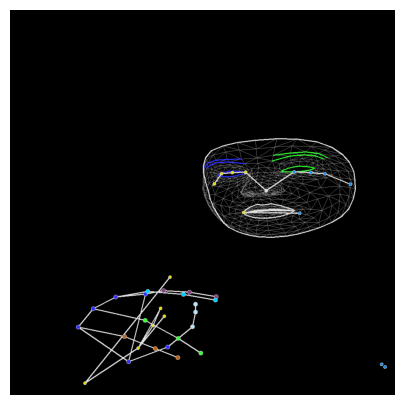

In [431]:
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)
Data, frame = video_data(V), 1
landmarks = get_landmarks_data(Data,frame)
show_image(draw_landmarks(landmarks,annotated_image))

## Plot: Scrolling through frames 

In [537]:
# Scrolling through frames
def show(V):
    # initialize the data from Video V
    Data = video_data(V)
    Frames = frames(V)
    # retrun frame function
    def show_frame(frame):
        landmarks = get_landmarks_data(Data,frame)
        show_image(draw_landmarks(landmarks,annotated_image), figsize=(7,7), title=f'frame: {frame} [{frame+1} of {len(Frames)}]')
    return show_frame

f = show(V)
interact(f, frame = widgets.IntSlider( min=0, max=len(V.frames)-1, step=0, value=0, layout=widgets.Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='frame', layout=Layout(width='1000px'), max=91, step=0), …

<function __main__.show.<locals>.show_frame(frame)>

## Plot: Dominant hand (only frame that it is visible)

In [635]:
GoodR = [4, 7, 10, 14, 15, 34, 82, 90, 100, 127, 131, 193, 219, 223, 228, 238, 339, 376, 386, 401, 457, 504, 510, 525, 528, 535, 538, 548, 570, 599, 611, 638, 651, 658, 692, 711, 784, 792, 804, 822, 835, 854, 864, 924, 940]
V = video(VideoID[4])

# basic predictor
label_data(V)
refined = refine_labels(V)

In [637]:
# Scrolling through image frames
# prediction_method = 'tflow' or 'kmeans'
def show_hands(V, prediction_method = 'tflow'):    
    
    # initialize
    Hframes = hand_frames(V)
    frames = V.frames
    phrase = V.phrase
    Data = video_data(V)
       
    # show function
    def show_frame(frame):
        # Only do frames with dominant hand
        frame = Hframes[frame]

        # Get landmark data
        landmarks = get_landmarks_data(Data, frame)

        # Remove face and pose landmarks 
        landmarks.face_landmarks = Landmark_make_nan(landmarks.face_landmarks)
        landmarks.pose_landmarks = Landmark_make_nan(landmarks.pose_landmarks)

        # set dominant hand (if left handed we reflect about the y-axis)
        if dominant_hand == 'left': landmarks.right_hand_landmarks = reflect(landmarks.left_hand_landmarks)

        # Plot original landmark and centered hand 
        landmarks.left_hand_landmarks = shift(landmarks.right_hand_landmarks, np.array([.2,.7,0]))
        landmarks.right_hand_landmarks = shift( center( landmarks.right_hand_landmarks, frame), np.array([.6,.7,0] ) )
        if prediction_method == 'kmeans': 
            show_image(draw_landmarks(landmarks,annotated_image),figsize=(6,6),title=f'frame [{frame+1} of {len(frames)}] {phrase:50} Prediction: {prediction(V,frame)}')
        elif prediction_method == 'tflow':
            show_image(draw_landmarks(landmarks,annotated_image),figsize=(6,6),title=f'frame [{frame+1} of {len(frames)}] {phrase:50} Prediction: {predict(V,frame)}')
        # print(f'showing frame: {frames[frame]}')
    
    return show_frame

f = show_hands(V, prediction_method = 'kmeans')
interact(f, frame=widgets.IntSlider(min=0, max=len(V.frames)-1, step=1, value=0, layout=widgets.Layout(width='1000px')))

interactive(children=(IntSlider(value=0, description='frame', layout=Layout(width='1000px'), max=244), Output(…

<function __main__.show_hands.<locals>.show_frame(frame)>

# Labeled Data - Method 1

In [527]:
# Pickling 
train_x, train_y = [],[]

# pickle function
def pickle(V, frame, letter):
    
    # initialize
    Data, _ = normal_hand_data(V)
    train_x.append( Data[frame] )
    train_y.append( letter )

In [548]:
for i in range(190):
    if prediction(V,i) != '?': 
        pickle(V, i, prediction(V,i) ) 

### Pickle

In [555]:
train = [ train_x, train_y ]
with open("pickle.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable 
    # if the data is nested
    json.dump(train, f, indent=2) 

### Unpickle

In [563]:
with open("pickle.json", 'r') as f:
    pickles = json.load(f)

# Labled Data - Method 2 
### TensorFlow trained on k-means data

In [622]:
train_x, train_y = pickles
train_y = [ Encode[i] for i in train_y ]

# Model
k = len( Characters )
M = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 3)),
    tf.keras.layers.Dense(6*k, activation='relu'),
    tf.keras.layers.Dense(k)])

# Compile Model
M.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# fit model
M.fit( train_x , train_y, epochs = 100, verbose=0 )

In [566]:
Loss, Acc = M.evaluate(train_x, train_y, verbose=2)
print('\nTest accuracy:', Acc)

12/12 - 0s - loss: 0.4382 - accuracy: 0.8777 - 77ms/epoch - 6ms/step

Test accuracy: 0.8777173757553101


### Tensorflow Predictions

In [588]:
# Prediction (tensor flow)
def predict(V, frame):

    Data, _ = normal_hand_data(V)
    Data = np.array([ Data[frame] ])
    
    # individual prediction
    X = tf.keras.Sequential([ M, tf.keras.layers.Softmax() ])
    p = X.predict( Data, verbose=0)
    
    # prediction (encoded as an integer)
    pred = np.argmax(p)
    
    # prediction (decoded)
    ans = Decode[pred]
    
    # return
    return ans 


# Sentence Reconstruction

In [638]:
# tolerence + video
def reconstruct_sentence(V, d):
    # initialize
    Frames = V.frames
    
    # pass 1 - store sucessive letter counts to a list
    ans = []
    letter = ''
    for i in Frames:
        x = predict(V,i)
        if not letter or x in letter: 
            letter += x 
        else: 
            ans += [ letter ]
            letter = x
    ans += [ letter ] 
    
    # pass 2 - For a give tolerence d, change any letters that occur on less than d consecutive frames to '?'
    ans0 = []
    for i in ans:
        k = len(i)
        if d < k: 
            ans0 += [i]
        else:
            y = '?' * k
            if ans0 and '?' in ans0[-1]: 
                ans0[-1] += y
            else:
                ans0 += [ y ]
    
    print(ans0)
            
    # pass 3 condennse to single letters
    ans1 = ''.join([ i[0] for i in ans if d < len(i) ])
    
    # return 
    return ans1
        

In [639]:
reconstruct_sentence(V,2)

['??', 'kkkkkkkkkkkkkkkkkkkkkk', 'nnnnnnn', 'eeeeeeeee', 'bbbbbb', '??', 'ooooo', 'nnnnn', 'eeeeeee', 'iiiiii', '??', 'sss', '??', 'ccccccccc', 'ooooo', 'nnnnnnnnnnnnnnnnnn', 'eeeeee', 'cccccccc', '?', 'tttt', '?', 'eeeeee', '??', 'ddddddd', 'tttt', '?', 'ooooooo', '?', 'ttttt', '?', 'hhhhh', '?', 'eeeee', '???', 'ttttttttt', '?', 'hhhhhhh', 'iiiiiii', '?', 'sss', '??', 'hhhhhhhhhhhh', '?', 'bbbbbbbbb', '?', 'oooo', 'nnnnn', 'eeeeeeee', 'jjj']


'kneboneisconectedtothethishbonej'

In [626]:
"""
# Scrolling through image frames
def show_frame(frame):
    frame = Hframes[frame]
    landmarks = get_landmarks_data(frame)
    landmarks.face_landmarks = Landmark_make_nan(landmarks.face_landmarks)
    landmarks.pose_landmarks = Landmark_make_nan(landmarks.pose_landmarks)
    if dominant_hand == 'left':
        landmarks.right_hand_landmarks = reflect(landmarks.left_hand_landmarks)
        landmarks.left_hand_landmarks = Landmark_make_nan(landmarks.left_hand_landmarks)
    landmarks.right_hand_landmarks = shift( center( landmarks.right_hand_landmarks, frame), np.array([.5,.7,0]))
    # show_image(draw_landmarks(landmarks,annotated_image),figsize=(9,9),title=f'Tflow Prediction: {predict(frame):10} Actual: {prediction(frame):10} frame: {frames[frame]} [{frame+1} of {len(frames)}]')
    show_image(draw_landmarks(landmarks,annotated_image),figsize=(9,9),title=f'Tflow Prediction: {predict(frame):10} {phrase:30} frame: {frames[frame]} [{frame+1} of {len(frames)}]')
    #print(f'showing frame: {frames[frame]}')


interact(show_frame, frame=widgets.IntSlider(min=0, max=len(Hframes)-1, step=1, value=0, layout=widgets.Layout(width='1000px')))
"""


hi


# Scripts for computing data 

# storing nice values for x,y,z

In [ ]:
'''
file = '33432165'
frame = 47
s = Video_ID[4] 
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)
landmarks = get_landmarks_data(frame)
show_image(draw_landmarks(landmarks,annotated_image))
X = fix_z(landmarks.right_hand_landmarks)

# Centering
X0 = Landmark_vector(X,0) # base
X1 = Landmark_vector(X,1) # left 
X5 = Landmark_vector(X,5) # center left 
X9 = Landmark_vector(X,9) # center
X13 = Landmark_vector(X,13) # center right
X17 = Landmark_vector(X,17) # right

# correct z
# X2[2] = predict_z( X2, Landmark_vector(X,10), Landmark_vector(X,11), Landmark_vector(X,12) )
# X2[2] = X.landmark[10].z  
    
# Basis 1
V1, V5, V9, V13, V17 = X1-X0, X5-X0, X9-X0, X13-X0, X17-X0

print( V1, V5, V9, V13, V17 ) 
'''

# Collecting complete videos

In [621]:
# Select video data
'''
GoodL, GoodR = [],[]
for j,x in enumerate(Video_ID):
    
    data = dataset.loc[x]
    data_labels = dataset_labels.loc[dataset_labels['sequence_id'] == x ]
    
    # All frames
    frames = data.frame.unique()

    # Right / Left hand frames
    Lframes = [i for i in frames if not Landmark_is_nan(get_landmarks('left_hand',i))]
    Rframes = [i for i in frames if not Landmark_is_nan(get_landmarks('right_hand',i))]
    
    # Dominant hand 
    if len(Lframes) < len(Rframes):
        Hframes = Rframes
        dominant_hand = "right"
    else:
        Hframes = Lframes
        dominant_hand = "left"
    
    print("Signer in %sth sequence is %s-handed and we have %s hand frames which comprise %s%% of the frames" % (j, dominant_hand, len(Hframes), round(100 * len(Hframes) / len(frames), 2)))
    if len(Hframes) == len(frames):
          if dominant_hand == 'right': GoodR += [j]
          else: GoodL += [j]
''' 

'\nGoodL, GoodR = [],[]\nfor j,x in enumerate(Video_ID):\n    \n    data = dataset.loc[x]\n    data_labels = dataset_labels.loc[dataset_labels[\'sequence_id\'] == x ]\n    \n    # All frames\n    frames = data.frame.unique()\n\n    # Right / Left hand frames\n    Lframes = [i for i in frames if not Landmark_is_nan(get_landmarks(\'left_hand\',i))]\n    Rframes = [i for i in frames if not Landmark_is_nan(get_landmarks(\'right_hand\',i))]\n    \n    # Dominant hand \n    if len(Lframes) < len(Rframes):\n        Hframes = Rframes\n        dominant_hand = "right"\n    else:\n        Hframes = Lframes\n        dominant_hand = "left"\n    \n    print("Signer in %sth sequence is %s-handed and we have %s hand frames which comprise %s%% of the frames" % (j, dominant_hand, len(Hframes), round(100 * len(Hframes) / len(frames), 2)))\n    if len(Hframes) == len(frames):\n          if dominant_hand == \'right\': GoodR += [j]\n          else: GoodL += [j]\n'

In [360]:
Vids = [ video(VideoID[i]) for i in GoodR ]

In [361]:
#[print(i) for i in Vids]
Goodchars = set(sum([[j[0] for j in i.characters] for i in Vids], []))

In [362]:
GoodFrames = [ normal_hand_data(i) for i in Vids]

In [363]:
F = sum([i[0] for i in GoodFrames], [])

In [364]:
k = len(Goodchars)
model = KMeans(n_clusters = k, n_init = 10, max_iter = 100)
data = np.array(F).reshape(len(F), -1) 
model.fit(data)

KMeans(max_iter=100, n_clusters=25, n_init=10)

In [365]:
centroids = [i.reshape(20,3) for i in model.cluster_centers_]

In [366]:
centroids[0]

array([[ 0.05233462, -0.0240227 ,  0.00271979],
       [ 0.08809012, -0.05999282,  0.00791376],
       [ 0.10096359, -0.08744536,  0.00163861],
       [ 0.10080147, -0.10537497, -0.00779836],
       [ 0.04130521, -0.09443814,  0.01054879],
       [ 0.06543527, -0.11884976, -0.00761136],
       [ 0.0807842 , -0.11327371, -0.01778912],
       [ 0.08748244, -0.10718146, -0.02153242],
       [ 0.00946415, -0.09018274, -0.00661085],
       [ 0.04290889, -0.10752123, -0.0297432 ],
       [ 0.05944271, -0.08307627, -0.03463637],
       [ 0.06187606, -0.06519644, -0.03196821],
       [-0.01967253, -0.08046315, -0.02715335],
       [ 0.0156788 , -0.09283737, -0.05102388],
       [ 0.03072455, -0.06902117, -0.04373665],
       [ 0.03097896, -0.05269207, -0.03177697],
       [-0.04786747, -0.06625001, -0.04892118],
       [-0.0211585 , -0.07961877, -0.06325546],
       [-0.00665645, -0.06915531, -0.05417681],
       [-0.00382645, -0.06164394, -0.04349613]])

In [367]:
def landmark_from_hand_data(c):
    
    # create a blank landmark
    X = blank()
    
    # create new landmark for left hand 
    obj = landmark_pb2.LandmarkList()
    
    # fill in new landmark
    obj.landmark.add( x=0, y=0, z=0 ) # origin is wrist
    for v in c: obj.landmark.add( x=v[0], y=v[1], z=v[2] ) # add other landmarks
    
    # set left hand to be obj
    X.left_hand_landmarks = obj
    X.left_hand_landmarks = shift(X.left_hand_landmarks, np.array([.5,.7,0]))
    
    return X   

<Axes: >

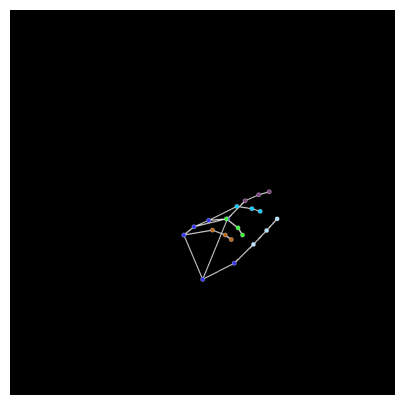

In [390]:
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)
landmarks = landmark_from_hand_data(centroids[14])
show_image(draw_landmarks(landmarks,annotated_image))

# Extras

In [ ]:
'''
#########################################
#### Measurements using hand model ######
#########################################

import sympy 
frame = 128
annotated_image = np.zeros((1024,1024,3),dtype=np.uint8)
landmarks = get_landmarks_data(frame)

# Triangle for hand 
X = landmarks.right_hand_landmarks

# z-prediction
from sympy import *
from sympy import sqrt
z1, z2 = symbols('z1, z2')

Measurements = {
 (0, 1) : 0.19917,
 (1, 2) : 0.18034,
 (2, 3) : 0.12843,
 (3, 4) : 0.09624,
 (0, 5) : 0.41711,
 (5, 6) : 0.16196,
 (6, 7) : 0.10277,
 (7, 8) : 0.08568,
 (0, 9) : 0.40355,
 (9, 10) : 0.18095,
 (10, 11) : 0.11845,
 (11, 12) : 0.09565,
 (0, 13) : 0.3855,
 (13, 14) : 0.16929,
 (14, 15) : 0.10963,
 (15, 16) : 0.09177,
 (0, 17) : 0.37061,
 (17, 18) : 0.13211,
 (18, 19) : 0.08178,
 (19, 20) : 0.07294 }

# z-prediction - given points 
def triangle_prediction(X,Y):
    
    # dummy variable for z value of X,Y
    V = [ X[0], X[1], z1 ] 
    W = [ Y[0], Y[1], z2 ]
    
    # Create Equations
    E1 = Eq( np.dot(V,W), sqrt(np.dot(V,V) * np.dot(W,W)) * (0.6781246776238563) ) # dot product a * b = |a||b| cos( theta )
    E2 = Eq( np.dot(V,V), np.dot(W,W) * (1.1254837879588218)**2 ) # Ratio
    
    # set determinant = 0 and solve 
    ans = list(nonlinsolve([E1,E2], [z1, z2]))
    # print(ans)
    
    # new z-coordinates
    z1_new, z2_new = float(ans[0][0]), float(ans[0][1])
    
    # return
    return z1_new, z2_new 


def fix_z(X):
    
    # shift to origin
    X = shift( X, np.array([0, 0, 0]) )
    
    ### Fundamental triangle 0--5--17
    # Build new (0,5) and (0,17) vectors
    X5, X17 = Landmark_vector(X, 5), Landmark_vector(X, 17) 
    X5[2], X17[2] = triangle_prediction(X5,X17)
    # print(X5[2], X17[2])
      
    # initialize measurements
    base = np.linalg.norm(X5)
    measurement_base = Measurements[(0,5)]
    
    # initizalize obj
    obj = landmark_pb2.LandmarkList()
    obj.landmark.add( x=0, y=0, z=0 ) # set 0 landmark to origin
    
    # loop 
    for i,j in Measurements:
        if (i,j) == (0,5): 
            obj.landmark.add( x=X5[0], y=X5[1], z=X5[2])
        elif (i,j) == (0,17):
            obj.landmark.add( x=X17[0], y=X17[1], z=X17[2] )
        else:
            # vector connecting i and j (use variable for z)
            Xi, Xj = Landmark_vector(obj, i), Landmark_vector(X, j)
            V = Xj - Xi
            V = [V[0], V[1], z1]
            
            # Equation
            E = Eq( sqrt(np.dot(V,V)) / base, Measurements[(i,j)] / measurement_base )

            # solution 
            corr = list(solveset(E, z1))
            # print( j, corr, Xj[2], Xi[2] + corr[0])
            
            corr = corr[0]
                  
            # convert to float if real, else set to 0
            corr = float(corr) if corr.is_real else 0

            # set coordinates
            obj.landmark.add( x=Xj[0], y=Xj[1], z=Xi[2] + corr )
    
    return obj
        

# Recenters a hand based on the outer landmarks 
def centered(X, frame):
    
    # if not defined
    if Landmark_is_nan(X): return X

    # Centering
    X0 = Landmark_vector(X,0) # base
    X1 = Landmark_vector(X,1) # left 
    X5 = Landmark_vector(X,5) # center left 
    X9 = Landmark_vector(X,9) # center
    X13 = Landmark_vector(X,13) # center right
    X17 = Landmark_vector(X,17) # right 
        
    # Possible basis vectors 
    Base = [ (1, X1-X0), (5, X5-X0), (9, X9-X0), (13, X13-X0), (17, X17-X0) ] 
    
    # Sort basis vectors by z-coordinates
    Base = sorted( Base, key=lambda x: x[1][2] )
    
    # Select vectors 
    L = [ Base[0] ] + [ sorted(Base[1:4], key=lambda x: abs(x[1][2] - Base[0][1][2]) * abs(x[1][2] - Base[4][1][2]))[2] ] + [ Base[4] ] 
    
    print(L)
    
    D = { 
    1  : [ 0.06816408, -0.02943546,  0.        ], 
    5  : [ 0.04396006, -0.13104451, -0.01766506], 
    9  : [ 0.00693706, -0.12849939, -0.04018739], 
    13 : [-0.02584845, -0.11831534, -0.04380703],
    17 : [-0.05505851, -0.10182643, -0.04391743] }
    
    # Basis Matrices
    A, B = np.array([i[1] for i in L]),  np.array([ D[i[0]] for i in L ])
    A1, B1 = np.array([ i[1] for i in Base[0:3]]),  np.array([ D[i] for i in [1,5,9]])
    print(A1,B1)
    
    # Transformation
    C = (np.linalg.inv(A)).dot(B)
    C1 = (np.linalg.inv(A1)).dot(B1)
    
    print(np.linalg.det(C), np.linalg.det(C1))
    # print( np.linalg.det(C), (np.linalg.norm(V5) / np.linalg.norm(V17) ), np.dot(V5,V17) / (np.linalg.norm(V5) * np.linalg.norm(V17))  )
    
    obj = landmark_pb2.LandmarkList()
    for i in X.landmark:
            
            # form vector
            v = np.array([i.x,i.y,i.z])
            
            # affine shift
            v = v - X0
            
            # linear transformation
            v = v.dot(C)
            
            # set coordinates
            obj.landmark.add( x=v[0], y=v[1], z=v[2] )
            
    return obj       

#########################################
###### Entropy (letter from phrase) #####
#########################################

sphrase = phrase.replace(" ", "")

def letter_predict(frame):
    i = math.floor( len(phrase) * frame / len(frames) ) 
    return phrase[i]

def letter_prediction(frame):
    i = bisect.bisect_left(T,frame)
    if len(sphrase) <= i: i = len(sphrase)-1
    return sphrase[i]

# fingers
hand_obj = { 'thumb' : [1,2,3,4], 'pointer' : [6,7,8], 'middle' : [10,11,12], 'ring' : [14,15,16], 'pinky' : [18,19,20], 'palm' : [0,5,9,13,17] }

# measure the sum of the distances between handlandmarks in any two frames 
def entropy(frame):
    
    L = []
    for frame in frames:
    
        # select hand landmarks from frame
        if dominant_hand == 'right': X = center( get_landmarks_data(frame).right_hand_landmarks, frame )
        else: X = center( get_landmarks_data(frame).left_hand_landmarks, frame )
    
        # check if defined
        if Landmark_is_nan(X): continue
        
        Eb, Ef = {}, {}
        for obj in hand_obj:
        
            # loop over landmarks and add to entropy
            db, df = 0, 0
            for i in hand_obj[obj]:
            
                # a = coordinates of i^th landmark in frame,  b = coordinate of i^th landmark in (frame - 1)
                a = Landmark_vector(X,i) 
                b = Landmark_vector(Y,i)
                c = Landmark_vector(Z,i) 
            
                # remove z-values
                a[2], b[2], c[2] = 0,0,0
            
                # distance 
                db += np.linalg.norm(a-b,2)
                df += np.linalg.norm(b-c,2)
            
            # add to entropy
            Eb[obj] = db
            Ef[obj] = df
    
    # total entropy
    teb = round( sum(Eb[i] for i in Eb) * 100 , 3 )
    tef = round( sum(Ef[i] for i in Ef) * 100 , 3 )
    
    # total entropy
    total_entropy = min(teb,tef)
    
    # print("heyo", teb, tef)
   
    # return entropy
    return total_entropy
'''        
        

In [ ]:
'''
# List all characters from sentence
# characters = V.characters
# frames = V.frames

# Good frames
# GoodFrames = [i for i in frames if prediction(V,i) != '?']

# training data
# train_data = [ V.normal_hand_data + V.hand_position for i in GoodFrames]
# train_predictions = [ Encode[prediction(V,i)] for i in GoodFrames ]
train_x, train_y = pickles
train_y = [ Encode[i] for i in train_y ]

# Model
k = len( Characters )
M = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 3)),
    tf.keras.layers.Dense(6*k, activation='relu'),
    tf.keras.layers.Dense(k)])

# Compile Model
M.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# fit model
M.fit( train_x , train_y, epochs = 100, verbose=0 )
'''